# Covid-19 Analysis

Looking at the Covid-19 data obtained from 'Our World in Data'.

**Index:**

- Extracting Data
    - Python imports
    - Fetch COVID-19 data from Our World in Data
    - Fetch Canadian specific data from [health-infobase.canada.ca](health-infobase.canada.ca)
- Filtering and Cleaning
    - Extract world record
    - Filtering for the latest data
    - Preparing population data
        -  Missing population data
    - Appending inferred information
    - Preparing Canadian specific data
- Analysis
    - World record
        - Plots
        - Table
    - Top 5: total cases per capita and deaths per total
        - Plots
        - Tables
    - Comparison between select countries
        - Plots
        - Tables
    - Highest number of total cases and deaths
        - Plots
        - Tables
    - Canadian provinces and territories
        - Canadian provinces and territories
        - Cases and Deaths
            - Plots
            - Tables
                - Total
                - Sorted by confirmed cases
        - Per Capita
            - Plots
            - Tables
                - Sorted by confirmed cases per capita
                - Population
- Resources

## Extracting coronavirus and country data

### Python Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import requests

from datetime import datetime

### Fetch COVID-19 data from Our World in Data

In [2]:
r = requests.get('https://covid.ourworldindata.org/data/ecdc/full_data.csv')

In [3]:
with open('full_data.csv', 'wb') as fd:
    for chunk in r.iter_content(chunk_size = 128):
        fd.write(chunk)

### Get Canadian specific data from health-infobase.canada.ca

In [4]:
r = requests.get('https://health-infobase.canada.ca/src/data/covidLive/covid19.csv')

In [5]:
with open('summary_current.csv', 'wb') as fd:
    for chunk in r.iter_content(chunk_size = 128):
        fd.write(chunk)

### Load data 

In [6]:
rdata = pd.read_csv('full_data.csv')
rpopulation_data = pd.read_csv('population_data.csv') 
canadian_data = pd.read_csv('summary_current.csv')
deaths_from_infections = pd.read_csv('deaths-from-infections-of-currently-noneradicable-diseases.csv')

In [7]:
canadian_population_dict = {'Population':[14711827, 8537674, 5110917, 4413146, 1377517, 1181666, 977457, 779993, 521365, 158158, 44904, 39097, 41078], 
                            'Location':['Ontario', 'Quebec', 'British Columbia', 'Alberta','Manitoba','Saskatchewan',
                                        'Nova Scotia', 'New Brunswick', 'Newfoundland and Labrador','Prince Edward Island', 'Northwest Territories','Nunavut','Yukon']}

canadian_population = pd.DataFrame.from_dict(canadian_population_dict)

## Filtering and cleaning data 

In [8]:
print("Data Types", rdata.dtypes)
print("Columns with NaN", rdata.columns[rdata.isna().any()])

Data Types date            object
location        object
new_cases        int64
new_deaths       int64
total_cases      int64
total_deaths     int64
dtype: object
Columns with NaN Index([], dtype='object')


In [9]:
pd.set_option("display.max_colwidth", -1)

In [10]:
rdata = rdata.fillna(value = 0)
pdata = rdata.astype({'new_cases':'int64', 
                     'new_deaths':'int64', 
                     'total_deaths':'int64'})
pdata.dtypes

date            object
location        object
new_cases       int64 
new_deaths      int64 
total_cases     int64 
total_deaths    int64 
dtype: object

In [11]:
rdata['date_fm'] = pd.to_datetime(rdata['date'], infer_datetime_format='%Y-%m-%d')

In [12]:
latest = pdata['date'].max()
latest

'2020-04-10'

In [13]:
canadian_data['date'] = pd.to_datetime(canadian_data['date'], infer_datetime_format='%d-%m-%Y')

In [14]:
latest_canadian = canadian_data['date'].max()

In [15]:
latest_year = deaths_from_infections['Year'].max()
latest_year

2017

In [16]:
deaths_from_infections.drop('Code', axis = 1, inplace = True)

In [17]:
deaths_from_infections = deaths_from_infections[deaths_from_infections['Year'] == latest_year]

In [18]:
deaths_from_infections.rename(inplace = True, columns = 
                              {'Entity':'Location', 
                               'Malaria (deaths)': 'Malaria',
                               'Tuberculosis (deaths)':'Tuberculosis',
                               'HIV/AIDS (deaths)':'HIV/AIDS',
                               'Rabies (deaths)':'Rabies'})

In [19]:
deaths_from_infections.set_index('Location', inplace = True)

In [20]:
earliest = '2020-03-01'

### Extract world record

In [21]:
world_record = rdata[rdata['location'] == 'World']

In [22]:
world_record = world_record.drop(columns = ['date'])
world_record = world_record.set_index('date_fm')

In [23]:
diff = datetime.today() - datetime.fromisoformat(rdata['date'].min())

In [24]:
world_deaths_from_infections = deaths_from_infections[deaths_from_infections.index == 'World'].copy()
world_deaths_from_infections.drop(inplace = True, columns = ['Year'])

In [25]:
scale = 365
world_deaths_from_infections_scaled = world_deaths_from_infections.copy()
world_deaths_from_infections_scaled['Malaria'] = (world_deaths_from_infections['Malaria'].div(scale))
world_deaths_from_infections_scaled['Tuberculosis'] = (world_deaths_from_infections['Tuberculosis'].div(scale))
world_deaths_from_infections_scaled['Rabies'] = (world_deaths_from_infections['Rabies'].div(scale))
world_deaths_from_infections_scaled['HIV/AIDS'] = (world_deaths_from_infections['HIV/AIDS'].div(scale))

In [26]:
covid_19 = world_record['total_deaths'][world_record.index == latest][0]/diff.days
world_deaths_from_infections_scaled = world_deaths_from_infections_scaled.assign(COVID_19 = covid_19)

### Filtering for the latest data

In [27]:
data = pdata[pdata['date'] == latest]
data = data.drop('date', axis = 1)
data = data.set_index('location')

In [28]:
data = data[data.index != 'World']

In [29]:
max_total_cases = data['total_cases'].max()

In [30]:
canadian_data = canadian_data[canadian_data['date'] == latest_canadian]
canadian_data = canadian_data.drop(columns = ['pruid', 'date','prnameFR'])

### Preparing population data

In [31]:
population = rpopulation_data.filter(['Country Name', '2018'])

In [32]:
population = population.rename(columns = {'Country Name':'location'})
population = population.set_index('location')

#### Missing population data

In [33]:
data[data.index.isin(population.index) == False]

,new_cases,new_deaths,total_cases,total_deaths
location,,,,
Anguilla,0,0,3,0
Bonaire Sint Eustatius and Saba,0,0,2,0
Falkland Islands,0,0,5,0
Guernsey,10,0,191,5
Jersey,13,0,183,3
Montserrat,0,0,9,0
Palestine,0,0,263,1
Saint Kitts and Nevis,0,0,11,0
Taiwan,1,0,380,5


### Appending inferred information 

In [34]:
data['total_cases_per_capita'] = data['total_cases'].div(data.index.map(population['2018'])).mul(100000)
data['total_deaths_per_capita'] = data['total_deaths'].div(data.index.map(population['2018'])).mul(100000)
data['deaths_per_total'] = data['total_deaths'].div(data['total_cases'])
data['deaths_per_total'] = data['deaths_per_total'].round(decimals = 4)
data.head()

,new_cases,new_deaths,total_cases,total_deaths,total_cases_per_capita,total_deaths_per_capita,deaths_per_total
location,,,,,,,
Afghanistan,61,1,484,15,1.302042,0.040353,0.0310
Albania,9,1,409,23,14.268889,0.802407,0.0562
Algeria,94,30,1666,235,3.945210,0.556497,0.1411
Andorra,19,2,583,25,757.083864,32.465003,0.0429
Angola,0,0,19,2,0.061669,0.006491,0.1053


### Preparing Canadian specific data

In [35]:
canadian_data = canadian_data.rename(columns = {'numconf': 'Confirmed Cases', 
                                                'numprob':'Probable Cases',
                                                'numtotal':'Total',
                                                'numtoday':'Today',
                                                'numdeaths': 'Deaths',
                                                'prname':'Location'})

In [36]:
canadian_data.set_index('Location', inplace = True)
canadian_population.set_index('Location', inplace = True)

In [37]:
canadian_data_total = canadian_data[canadian_data.index == 'Canada']

In [38]:
canadian_data = canadian_data[canadian_data.index.isin(canadian_population.index) == True]
canadian_population = canadian_population[canadian_population.index.isin(canadian_data.index) == True]

In [39]:
canadian_data['Deaths per Confirmed Cases'] = (canadian_data['Deaths'].div(canadian_data['Confirmed Cases']))

In [40]:
canadian_data = canadian_data.assign(Confirmed_Cases_Per_Capita = canadian_data['Confirmed Cases'].div(canadian_population['Population']))
canadian_data = canadian_data.assign(Deaths_Per_Capita = canadian_data['Deaths'].div(canadian_population['Population']))

In [41]:
canadian_data.rename(columns = {'Confirmed_Cases_Per_Capita':'Confirmed Cases Per Capita', 
                                'Deaths_Per_Capita':'Deaths Per Capita'}, inplace = True)

## Analysis

### World record

#### Plots

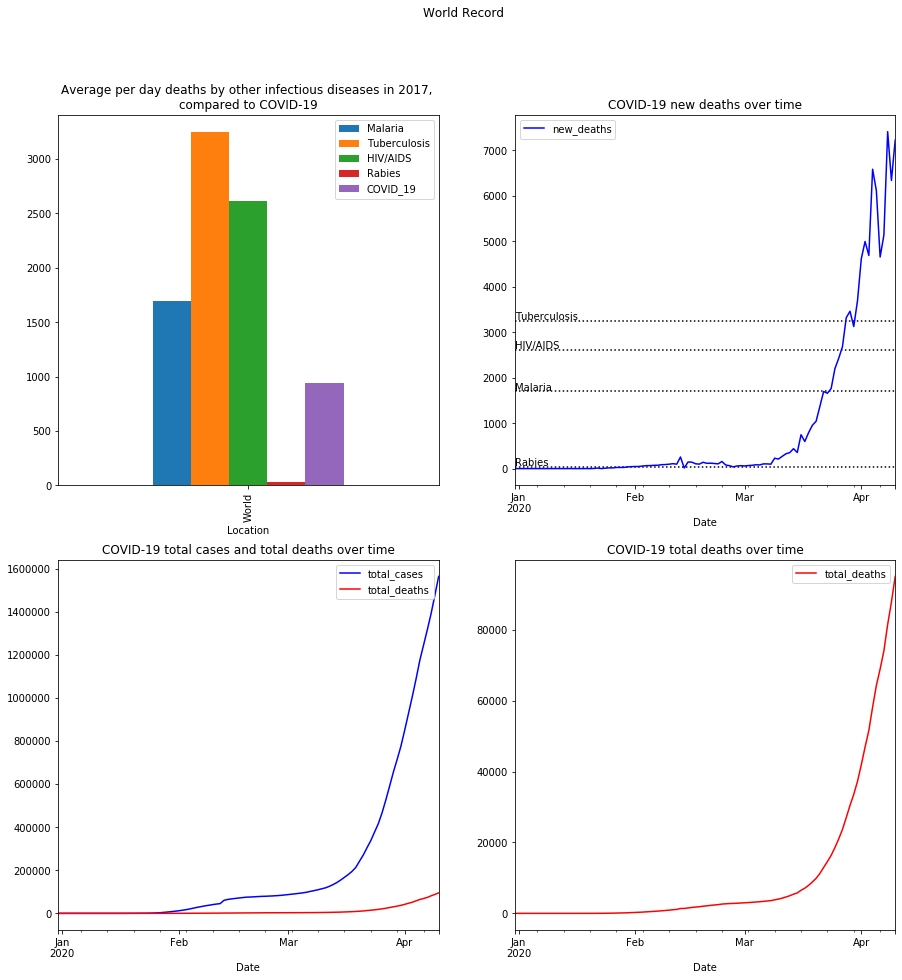

In [42]:
fig, ((ax3, ax4), (ax1, ax2)) = plt.subplots(2, 2, figsize = (15,15))
fig.suptitle('World Record')

world_record.index.name = 'Date'

# set titles

ax1.set_title('COVID-19 total cases and total deaths over time')
ax2.set_title('COVID-19 total deaths over time')

diffy = 26
ax3_title = 'Average per day deaths by other infectious diseases in ' + str(latest_year) +', \ncompared to COVID-19'
ax3.set_title(ax3_title)

ax4.set_title('COVID-19 new deaths over time')

world_record.plot(kind='line', y= ['total_cases', 'total_deaths'], color = ['blue', 'red'], ax = ax1)
world_record.plot(kind='line', y= 'total_deaths', color = 'red', ax = ax2)
world_deaths_from_infections_scaled.plot(kind = 'bar', ax = ax3)
world_record.plot(kind='line', y= 'new_deaths', color = 'blue', ax = ax4)

ax4.hlines(world_deaths_from_infections_scaled['Malaria'], world_record.index.min(), world_record.index.max(), linestyles = 'dotted')
ax4.text(world_record.index.min(), world_deaths_from_infections_scaled['Malaria']+diffy, 'Malaria')

ax4.hlines(world_deaths_from_infections_scaled['Rabies'], world_record.index.min(), world_record.index.max(), linestyles = 'dotted')
ax4.text(world_record.index.min(), world_deaths_from_infections_scaled['Rabies']+diffy, 'Rabies')

ax4.hlines(world_deaths_from_infections_scaled['Tuberculosis'], world_record.index.min(), world_record.index.max(), linestyles = 'dotted')
ax4.text(world_record.index.min(), world_deaths_from_infections_scaled['Tuberculosis']+diffy, 'Tuberculosis')

ax4.hlines(world_deaths_from_infections_scaled['HIV/AIDS'], world_record.index.min(), world_record.index.max(), linestyles = 'dotted')
ax4.text(world_record.index.min(), world_deaths_from_infections_scaled['HIV/AIDS']+diffy, 'HIV/AIDS')

plt.savefig('world.png', bbox_inches = 'tight')

#### Table

In [43]:
world_record[world_record.index == latest]

,location,new_cases,new_deaths,total_cases,total_deaths
Date,,,,,
2020-04-10,World,87039,7228,1563857,95044


In [44]:
world_deaths_from_infections

,Malaria,Tuberculosis,HIV/AIDS,Rabies
Location,,,,
World,619826.63466,1.183672e+06,954491.747216,11659.073233


In [45]:
world_deaths_from_infections_scaled

,Malaria,Tuberculosis,HIV/AIDS,Rabies,COVID_19
Location,,,,,
World,1698.155163,3242.937234,2615.045883,31.942666,941.029703


### Top 5: total cases per capita and deaths per total

In [46]:
highest_total_cases_pc = data.nlargest(5, 'total_cases_per_capita')

In [47]:
highest_total_cases_pc = highest_total_cases_pc.merge(population, on = 'location')

In [48]:
deaths_per_cases = data[data['total_cases'] > 50].nlargest(5, 'deaths_per_total')
deaths_per_cases = deaths_per_cases.merge(population, on = 'location')

In [49]:
total_cases_for_table = highest_total_cases_pc.drop(columns = ['total_deaths_per_capita', 'deaths_per_total', 'new_deaths', 'total_deaths'])
total_cases_for_table = total_cases_for_table.reset_index()
total_cases_for_table = total_cases_for_table.rename(columns = {'2018':'population'})

In [50]:
deathsratio_for_table = deaths_per_cases.drop(columns = ['new_cases', 'new_deaths', 'total_cases_per_capita', 'total_deaths_per_capita'])
deathsratio_for_table = deathsratio_for_table.reset_index()
deathsratio_for_table = deathsratio_for_table.rename(columns = {'2018':'population'})

#### Plots

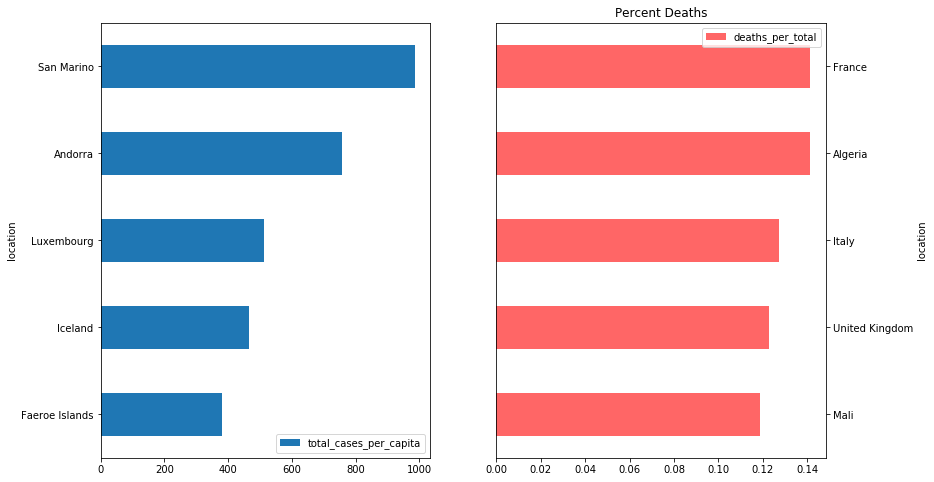

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 8))
highest_total_cases_pc.sort_values(by = 'total_cases_per_capita', ascending = True).plot(kind='barh',y = 'total_cases_per_capita', ax = ax1,
                            ylim = (0, data['total_cases_per_capita'].max()+ 0.0005))

ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()
ax2.set_title('Percent Deaths')
deaths_per_cases.sort_values(by = 'deaths_per_total', ascending = True).plot.barh(y = 'deaths_per_total', 
                                                      color ='red', ax = ax2,
                                                      alpha = 0.6)
plt.savefig('total_cases_per_capita_and_deaths_per_total.png', bbox_inches = 'tight')

#### Tables

##### Highest total cases per capita

In [52]:
total_cases_for_table

,location,new_cases,total_cases,total_cases_per_capita,population
0,San Marino,25,333,985.644517,33785.0
1,Andorra,19,583,757.083864,77006.0
2,Luxembourg,81,3115,512.564832,607728.0
3,Iceland,32,1648,466.097620,353574.0
4,Faeroe Islands,0,184,379.404912,48497.0


##### Highest deaths to total cases

In [53]:
deathsratio_for_table

,location,total_cases,total_deaths,deaths_per_total,population
0,France,86334,12210,0.1414,66987244.0
1,Algeria,1666,235,0.1411,42228429.0
2,Italy,143626,18281,0.1273,60431283.0
3,United Kingdom,65077,7978,0.1226,66488991.0
4,Mali,59,7,0.1186,19077690.0


### Comparison between select countries

In [54]:
filter_countries = ['Canada','United States', 'Pakistan', 'China', 'Italy']

In [55]:
country_subset = rdata[rdata['location'].isin(filter_countries) & rdata['date_fm'].between(earliest, latest)]
country_subset = country_subset.drop(columns = ['date'])
country_subset = country_subset.set_index('date_fm')
country_subset.index.name = 'Date'

In [56]:
percapita = pd.DataFrame(country_subset['location'])
percapita['new_cases_per_capita'] =  country_subset['new_cases'].div(country_subset['location'].map(population['2018'])).mul(100000)

In [57]:
percapita_total = pd.DataFrame(country_subset['location'])
percapita_total['total_cases_per_capita'] =  country_subset['total_cases'].div(country_subset['location'].map(population['2018'])).mul(100000)

In [58]:
percapita_deaths = pd.DataFrame(country_subset['location'])
percapita_deaths['new_deaths_per_capita'] =  country_subset['new_deaths'].div(country_subset['location'].map(population['2018'])).mul(100000)

#### Plots

##### By new cases

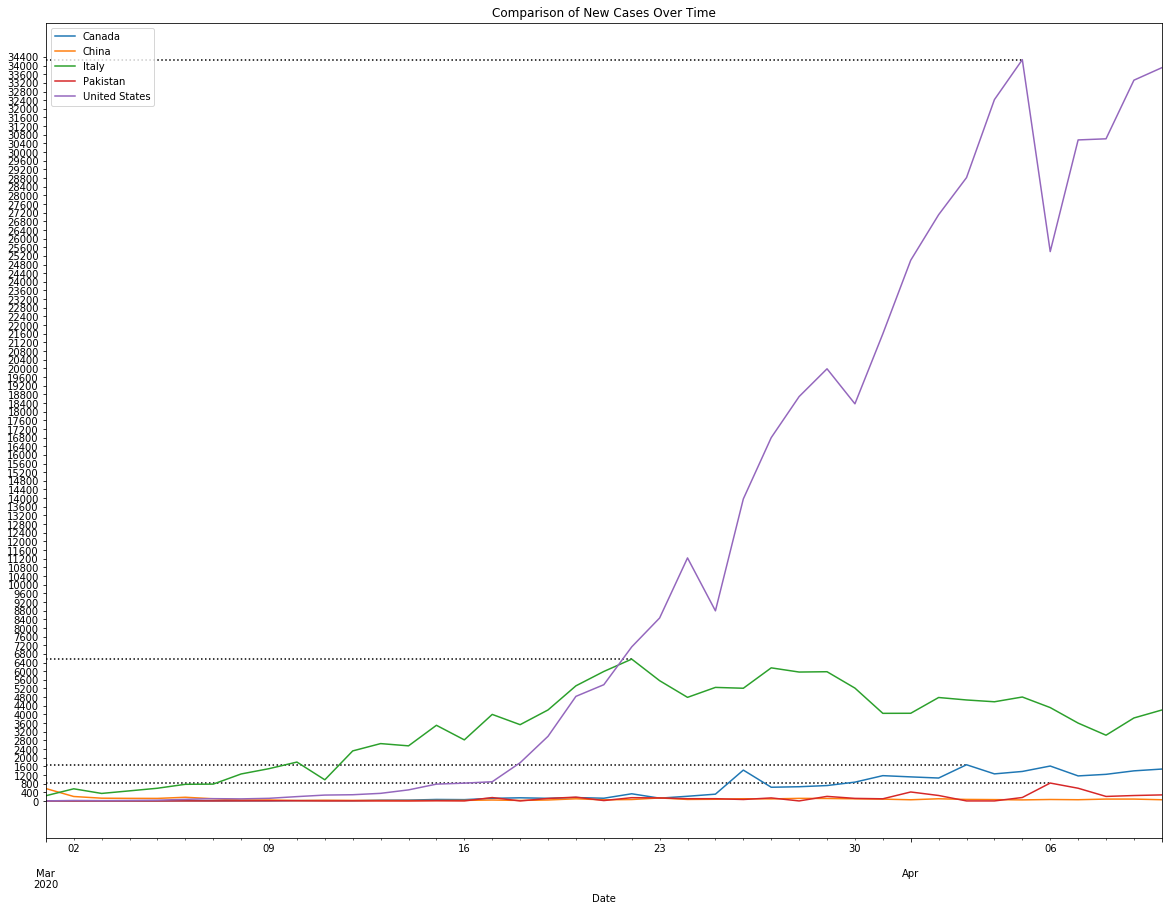

In [59]:
inc = 400

_, ax = plt.subplots(figsize = (20, 15))
ax.set_title('Comparison of New Cases Over Time')
ax.set_yticks(np.arange(0, country_subset['new_cases'].max()+inc, inc))

for name, group in country_subset.groupby('location'):
    group.plot(kind ='line', y = 'new_cases', ax = ax, label = name)
    
    max_record = group.loc[group['new_cases'].idxmax()]
    max_date = pd.to_datetime(max_record.name)
    max_new_cases = max_record['new_cases']
    plt.hlines(max_new_cases, earliest, max_date, linestyles = 'dotted')

plt.savefig('select_countries_new_cases.png', bbox_inches = 'tight')

##### New cases per capita

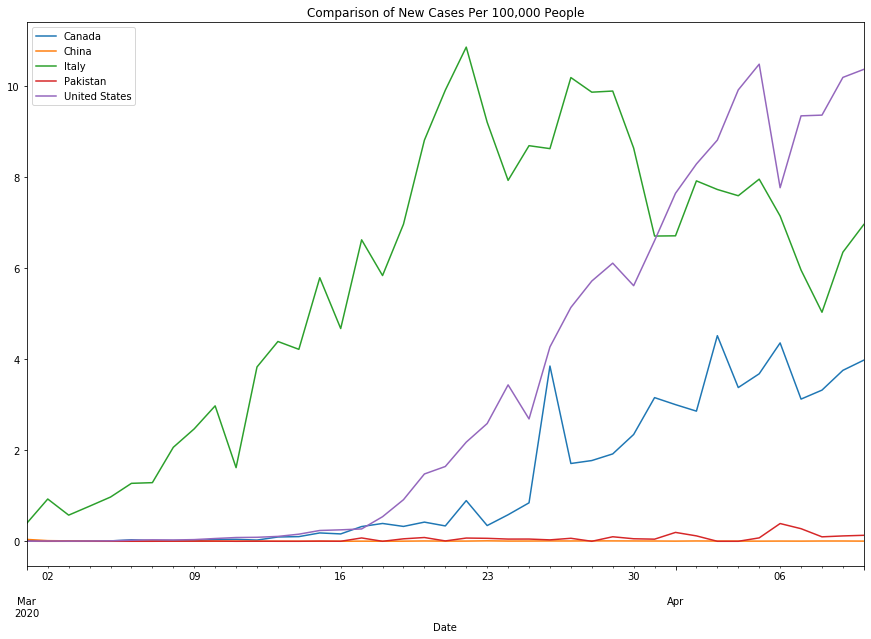

In [60]:
_, ax = plt.subplots(figsize = (15, 10))

ax.set_title('Comparison of New Cases Per 100,000 People')

for name, group in percapita.groupby('location'):
    group.plot(kind ='line', y = 'new_cases_per_capita', ax = ax, label = name)

plt.savefig('select_countries_new_cases_per_capita.png', bbox_inches = 'tight')

##### Total cases per capita

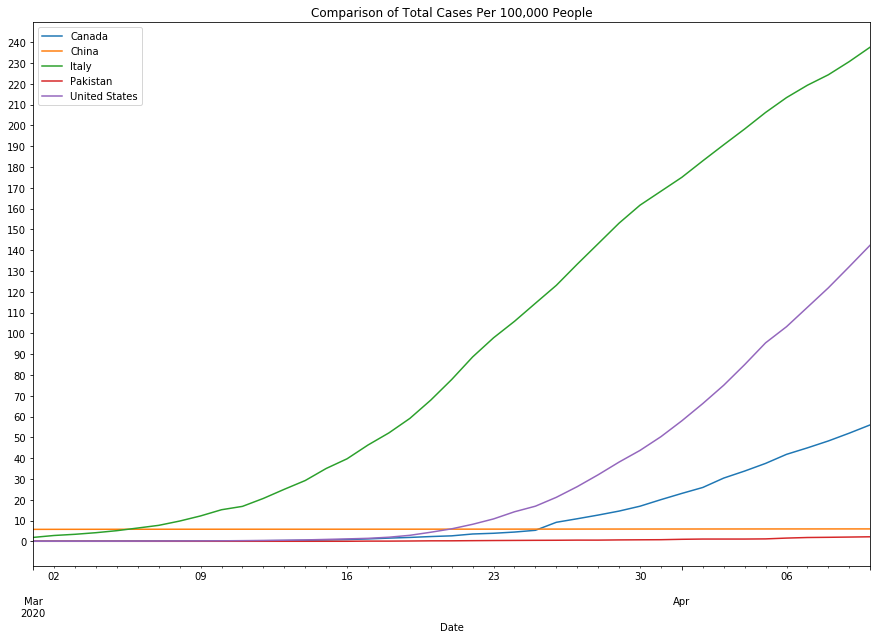

In [61]:
inc = 10

_, ax = plt.subplots(figsize = (15, 10))

ax.set_title('Comparison of Total Cases Per 100,000 People')
ax.set_yticks(np.arange(0, percapita_total['total_cases_per_capita'].max()+inc, inc))

for name, group in percapita_total.groupby('location'):
    group.plot(kind ='line', y = 'total_cases_per_capita', ax = ax, label = name)

plt.savefig('select_countries_total_cases_per_capita.png', bbox_inches = 'tight')

In [62]:
country_subset_latest = country_subset[country_subset.index == latest]
country_subset_latest

,location,new_cases,new_deaths,total_cases,total_deaths
Date,,,,,
2020-04-10,Canada,1474,74,20748,509
2020-04-10,China,55,1,82925,3340
2020-04-10,Italy,4204,612,143626,18281
2020-04-10,Pakistan,279,3,4601,66
2020-04-10,United States,33901,1873,466033,16690


##### New deaths per capita

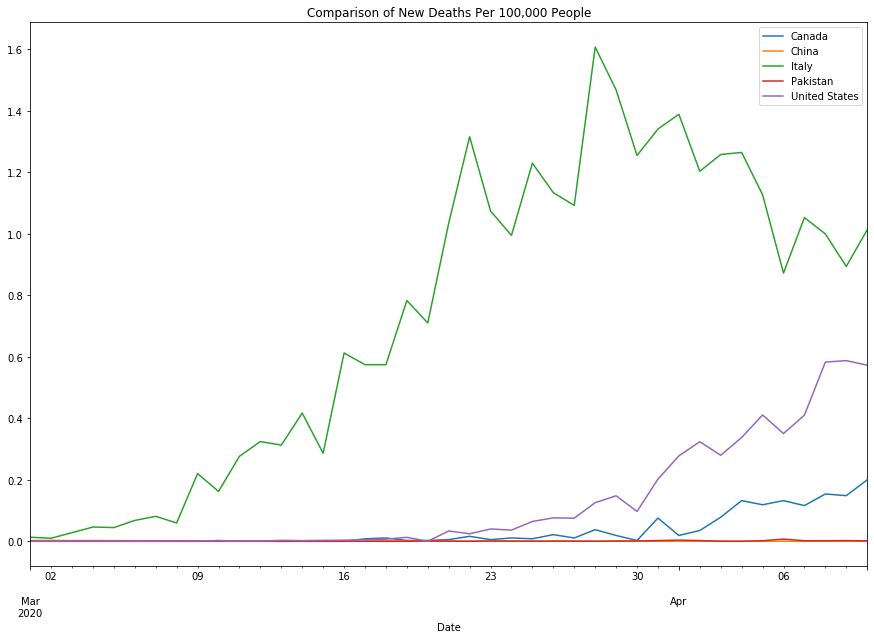

In [63]:
_, ax = plt.subplots(figsize = (15, 10))

ax.set_title('Comparison of New Deaths Per 100,000 People')

for name, group in percapita_deaths.groupby('location'):
    group.plot(kind ='line', y = 'new_deaths_per_capita', ax = ax, label = name)

plt.savefig('select_countries_new_deaths_per_capita.png', bbox_inches = 'tight')

### Highest number of total cases and deaths

In [64]:
highest_total_cases = data.nlargest(5, 'total_cases')
highest_deaths = data.nlargest(5, 'total_deaths')

#### Plots

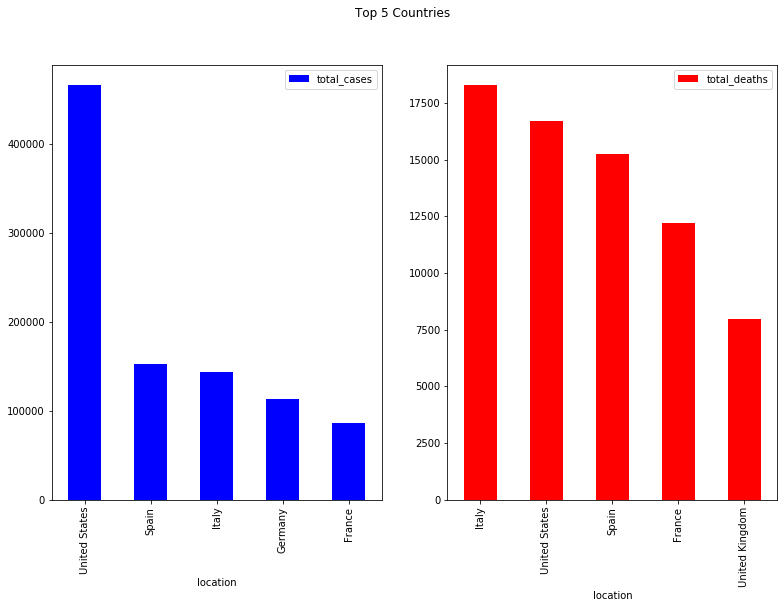

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 8))
fig.suptitle('Top 5 Countries')

highest_total_cases.plot(kind = 'bar', y = 'total_cases', color = ['blue'], ax = ax1)
highest_deaths.plot(kind = 'bar', y = 'total_deaths', color = ['red'], ax = ax2)
plt.savefig('highest_total_cases_and_deaths.png', bbox_inches = 'tight')

#### Tables

##### Highest total cases

In [66]:
highest_total_cases

,new_cases,new_deaths,total_cases,total_deaths,total_cases_per_capita,total_deaths_per_capita,deaths_per_total
location,,,,,,,
United States,33901,1873,466033,16690,142.444801,5.101363,0.0358
Spain,5756,683,152446,15238,326.270908,32.612965,0.1000
Italy,4204,612,143626,18281,237.668295,30.250888,0.1273
Germany,5323,266,113525,2373,136.895990,2.861521,0.0209
France,4286,1341,86334,12210,128.881254,18.227351,0.1414


##### Highest total deaths

In [67]:
highest_deaths

,new_cases,new_deaths,total_cases,total_deaths,total_cases_per_capita,total_deaths_per_capita,deaths_per_total
location,,,,,,,
Italy,4204,612,143626,18281,237.668295,30.250888,0.1273
United States,33901,1873,466033,16690,142.444801,5.101363,0.0358
Spain,5756,683,152446,15238,326.270908,32.612965,0.1000
France,4286,1341,86334,12210,128.881254,18.227351,0.1414
United Kingdom,4344,881,65077,7978,97.876354,11.998979,0.1226


### Canadian provinces and territories

#### Cases and Deaths

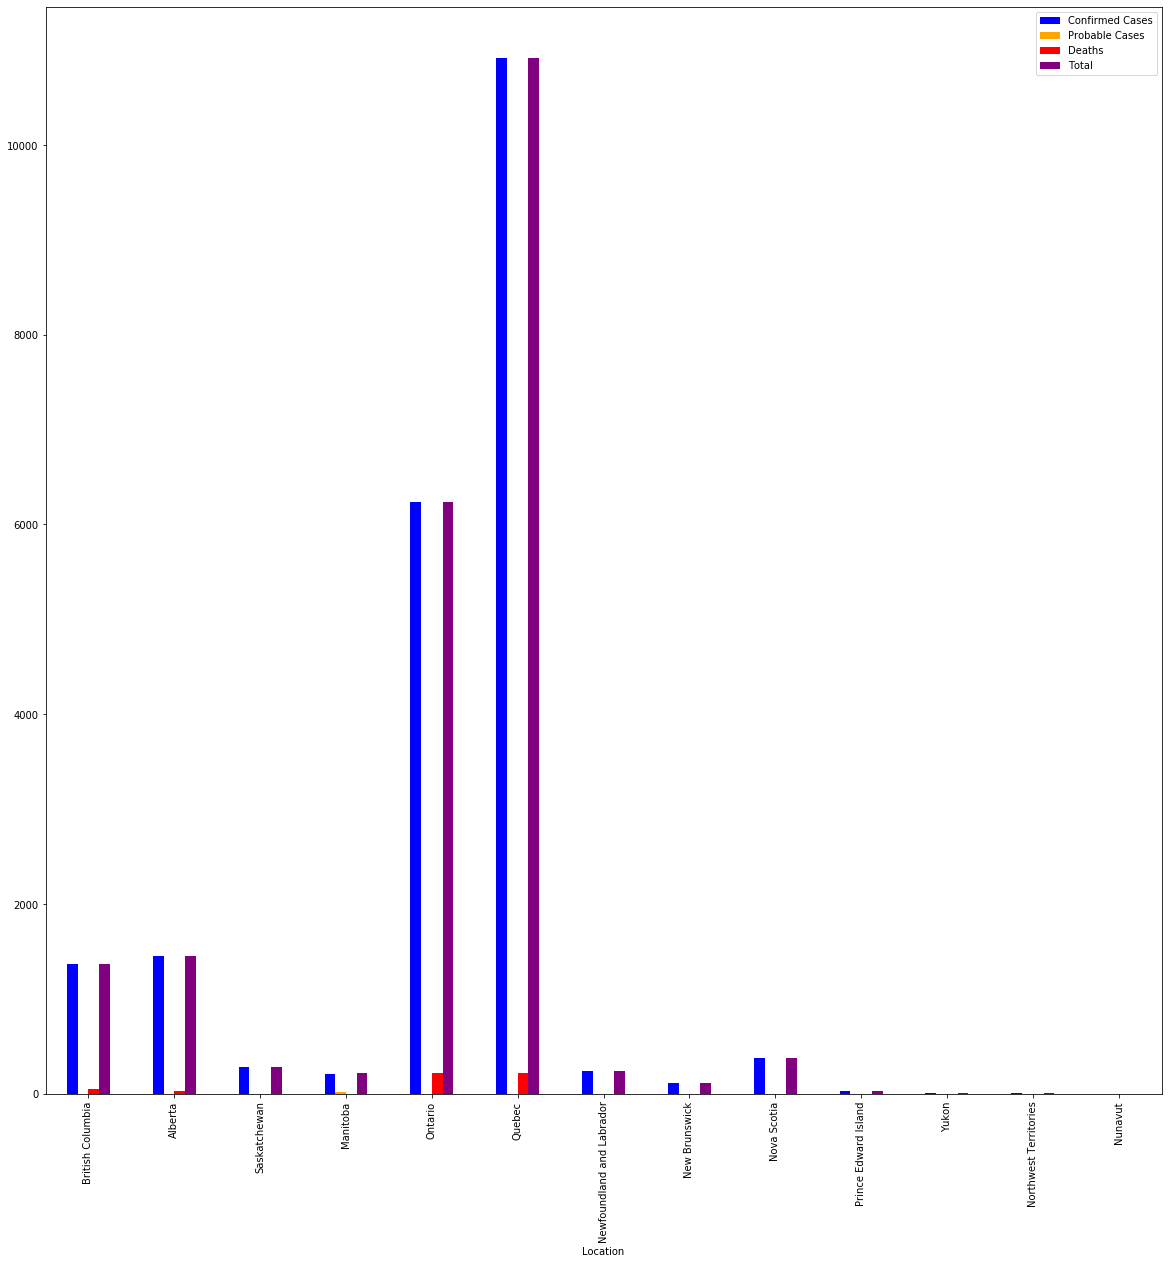

In [68]:
canadian_data.plot(kind = 'bar', y = ['Confirmed Cases', 'Probable Cases', 'Deaths', 'Total'], color = ['blue', 'orange', 'red', 'purple'], figsize = (20,20))
plt.savefig('canadian_provinces_all.png', bbox_inches = 'tight')

In [69]:
canadian_data.sort_values(by = 'Confirmed Cases', ascending = False, inplace = True)

##### Plots

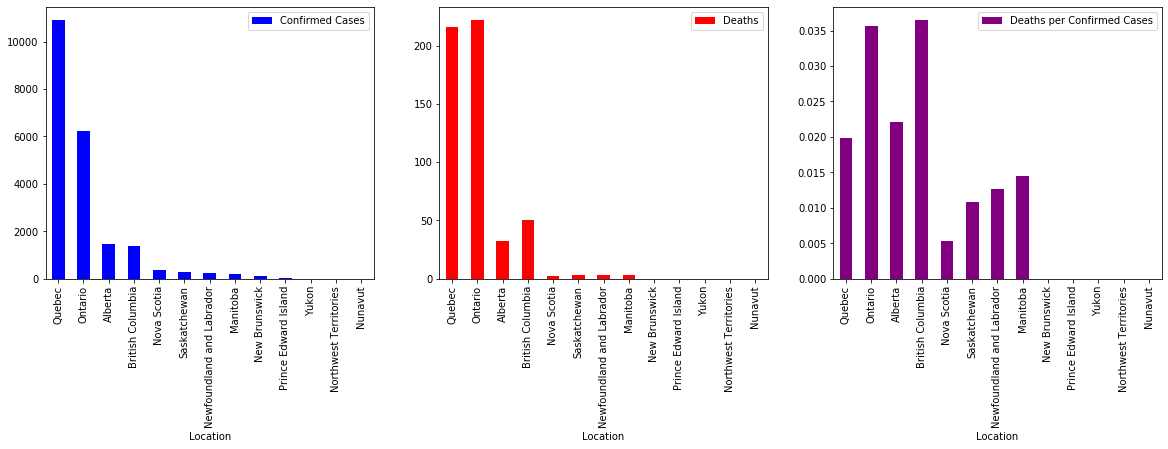

In [70]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
canadian_data.plot(kind = 'bar', y = 'Confirmed Cases', color = ['blue'], ax = ax1)
canadian_data.plot(kind = 'bar', y = 'Deaths', color = ['red'], ax = ax2)
canadian_data.plot(kind = 'bar', y = 'Deaths per Confirmed Cases', color = ['purple'], ax = ax3)
plt.savefig('canadian_provinces.png', bbox_inches = 'tight')

##### Tables

###### Total

In [71]:
canadian_data_total

,Confirmed Cases,Probable Cases,Deaths,Total,numtested,numrecover,percentrecover,ratetested,Today,percentoday
Location,,,,,,,,,,
Canada,21226,17,531,21243,383322.0,NaN,NaN,NaN,NaN,NaN


###### Sorted by confirmed cases

In [72]:
canadian_data

,Confirmed Cases,Probable Cases,Deaths,Total,numtested,numrecover,percentrecover,ratetested,Today,percentoday,Deaths per Confirmed Cases,Confirmed Cases Per Capita,Deaths Per Capita
Location,,,,,,,,,,,,,
Quebec,10912,0,216,10912,118217.0,NaN,NaN,NaN,NaN,NaN,0.019795,0.001278,0.000025
Ontario,6237,0,222,6237,89906.0,NaN,NaN,NaN,NaN,NaN,0.035594,0.000424,0.000015
Alberta,1451,0,32,1451,68116.0,NaN,NaN,NaN,NaN,NaN,0.022054,0.000329,0.000007
British Columbia,1370,0,50,1370,46236.0,NaN,NaN,NaN,NaN,NaN,0.036496,0.000268,0.000010
Nova Scotia,373,0,2,373,13881.0,NaN,NaN,NaN,NaN,NaN,0.005362,0.000382,0.000002
Saskatchewan,278,0,3,278,16952.0,NaN,NaN,NaN,NaN,NaN,0.010791,0.000235,0.000003
Newfoundland and Labrador,236,0,3,236,4520.0,NaN,NaN,NaN,NaN,NaN,0.012712,0.000453,0.000006
Manitoba,207,17,3,224,14569.0,NaN,NaN,NaN,NaN,NaN,0.014493,0.000150,0.000002
New Brunswick,111,0,0,111,7172.0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000142,0.000000


#### Per Capita

##### Plots

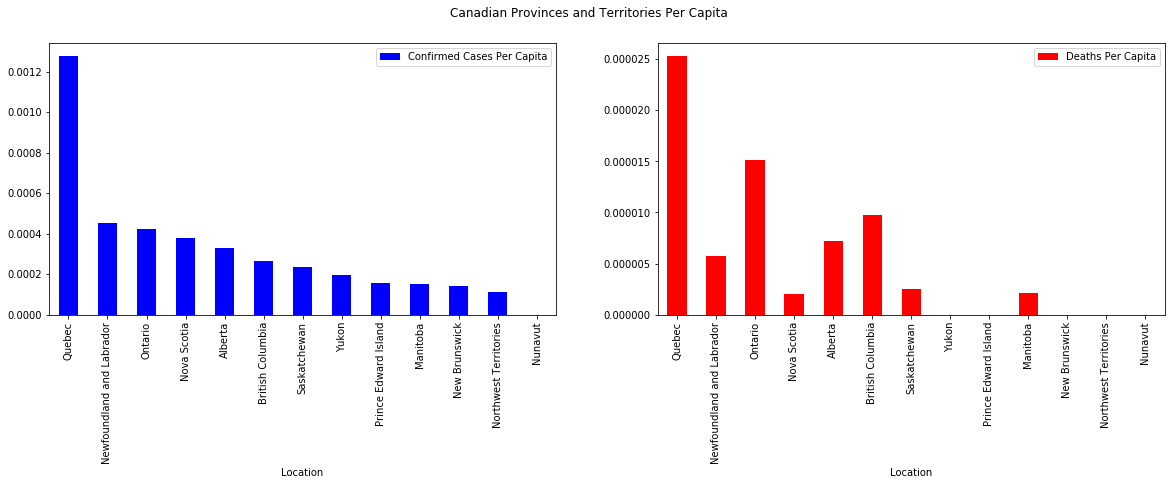

In [73]:
cdata_sorted = canadian_data.sort_values(by = 'Confirmed Cases Per Capita', ascending = False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Canadian Provinces and Territories Per Capita')

cdata_sorted.plot(kind = 'bar', y = 'Confirmed Cases Per Capita', color = ['blue'], ax = ax1)
cdata_sorted.plot(kind = 'bar', y = 'Deaths Per Capita', color = ['red'], ax = ax2)

plt.savefig('canadian_provinces_per_capita.png', bbox_inches = 'tight')

##### Tables

###### Sorted by confirmed cases per capita

In [74]:
cdata_sorted

,Confirmed Cases,Probable Cases,Deaths,Total,numtested,numrecover,percentrecover,ratetested,Today,percentoday,Deaths per Confirmed Cases,Confirmed Cases Per Capita,Deaths Per Capita
Location,,,,,,,,,,,,,
Quebec,10912,0,216,10912,118217.0,NaN,NaN,NaN,NaN,NaN,0.019795,0.001278,0.000025
Newfoundland and Labrador,236,0,3,236,4520.0,NaN,NaN,NaN,NaN,NaN,0.012712,0.000453,0.000006
Ontario,6237,0,222,6237,89906.0,NaN,NaN,NaN,NaN,NaN,0.035594,0.000424,0.000015
Nova Scotia,373,0,2,373,13881.0,NaN,NaN,NaN,NaN,NaN,0.005362,0.000382,0.000002
Alberta,1451,0,32,1451,68116.0,NaN,NaN,NaN,NaN,NaN,0.022054,0.000329,0.000007
British Columbia,1370,0,50,1370,46236.0,NaN,NaN,NaN,NaN,NaN,0.036496,0.000268,0.000010
Saskatchewan,278,0,3,278,16952.0,NaN,NaN,NaN,NaN,NaN,0.010791,0.000235,0.000003
Yukon,8,0,0,8,806.0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000195,0.000000
Prince Edward Island,25,0,0,25,1435.0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000158,0.000000


###### Population

In [75]:
canadian_population

,Population
Location,
Ontario,14711827
Quebec,8537674
British Columbia,5110917
Alberta,4413146
Manitoba,1377517
Saskatchewan,1181666
Nova Scotia,977457
New Brunswick,779993
Newfoundland and Labrador,521365


## Resources
1. Data obtained from: https://ourworldindata.org/coronavirus-source-data
2. Population data from: https://data.worldbank.org/indicator/SP.POP.TOTL
3. Canadian data: https://www.canada.ca/en/public-health/services/diseases/2019-novel-coronavirus-infection.html
4. Canadian population: https://en.wikipedia.org/wiki/List_of_Canadian_provinces_and_territories_by_population
5. Deaths from infectious diseases: https://ourworldindata.org/grapher/deaths-from-infections-of-currently-noneradicable-diseases
6. Tuberculosis: https://www.doctorswithoutborders.ca/issues/tuberculosis-deadly-and-neglected